In [1]:
%matplotlib inline

# Context module with nilearn data
Decoding a nilearn-based surface-based fMRI second level analysis (adopted from: https://nilearn.github.io/dev/auto_examples/07_advanced/plot_surface_bids_analysis.html) 

In [2]:
# nilearn decoding, first do some nilearn things 
from nilearn.datasets import fetch_language_localizer_demo_dataset
from nilearn.glm.first_level import first_level_from_bids

data_dir, _ = fetch_language_localizer_demo_dataset()
task_label = 'languagelocalizer'
_, models_run_imgs, models_events, models_confounds = \
    first_level_from_bids(
        data_dir, task_label,
        img_filters=[('desc', 'preproc')])

/Users/saratheriver/opt/anaconda3/envs/py3.8/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/Users/saratheriver/opt/anaconda3/envs/py3.8/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:940: UserWarning: SliceTimingRef not found in file /Users/saratheriver/nilearn_data/fMRI-language-localizer-demo-dataset/derivatives/sub-01/func/sub-01_task-languagelocalizer_desc-preproc_bold.json. It will be assumed that the slice timing reference is 0.0 percent of the repetition time. If it is not the case it will need to be set manually in the generated list of models
  warn('SliceTimingRef not found in file %s. It will be assumed'


In [3]:
# obtain first level Model objects and arguments 
from nilearn.glm.first_level import first_level_from_bids

task_label = 'languagelocalizer'
_, models_run_imgs, models_events, models_confounds = \
    first_level_from_bids(
        data_dir, task_label,
        img_filters=[('desc', 'preproc')])

import os
json_file = os.path.join(data_dir, 'derivatives', 'sub-01', 'func',
                         'sub-01_task-languagelocalizer_desc-preproc_bold.json')
import json
with open(json_file, 'r') as f:
    t_r = json.load(f)['RepetitionTime']

/Users/saratheriver/opt/anaconda3/envs/py3.8/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:940: UserWarning: SliceTimingRef not found in file /Users/saratheriver/nilearn_data/fMRI-language-localizer-demo-dataset/derivatives/sub-01/func/sub-01_task-languagelocalizer_desc-preproc_bold.json. It will be assumed that the slice timing reference is 0.0 percent of the repetition time. If it is not the case it will need to be set manually in the generated list of models
  warn('SliceTimingRef not found in file %s. It will be assumed'


In [4]:
# project onto fsaverage
from nilearn.datasets import fetch_surf_fsaverage
fsa = fetch_surf_fsaverage(mesh='fsaverage5')

import numpy as np
from nilearn import surface
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.glm.first_level import run_glm
from nilearn.glm.contrasts import compute_contrast

z_scores_right = []
z_scores_left = []
for (fmri_img, confound, events) in zip(
        models_run_imgs, models_confounds, models_events):
    texture = surface.vol_to_surf(fmri_img[0], fsa.pial_right)
    n_scans = texture.shape[1]
    frame_times = t_r * (np.arange(n_scans) + .5)

    # Create the design matrix
    #
    # We specify an hrf model containing Glover model and its time derivative.
    # The drift model is implicitly a cosine basis with period cutoff 128s.
    design_matrix = make_first_level_design_matrix(
        frame_times, events=events[0], hrf_model='glover + derivative',
        add_regs=confound[0])

    # Contrast specification
    contrast_values = (design_matrix.columns == 'language') * 1.0 -\
                      (design_matrix.columns == 'string')

    # Setup and fit GLM.
    # Note that the output consists in 2 variables: `labels` and `fit`
    # `labels` tags voxels according to noise autocorrelation.
    # `estimates` contains the parameter estimates.
    # We input them for contrast computation.
    labels, estimates = run_glm(texture.T, design_matrix.values)
    contrast = compute_contrast(labels, estimates, contrast_values,
                                contrast_type='t')
    # We present the Z-transform of the t map.
    z_score = contrast.z_score()
    z_scores_right.append(z_score)

    # Do the left hemisphere exactly the same way.
    texture = surface.vol_to_surf(fmri_img, fsa.pial_left)
    labels, estimates = run_glm(texture.T, design_matrix.values)
    contrast = compute_contrast(labels, estimates, contrast_values,
                                contrast_type='t')
    z_scores_left.append(contrast.z_score())

from scipy.stats import ttest_1samp, norm

t_left, pval_left = ttest_1samp(np.array(z_scores_left), 0)
t_right, pval_right = ttest_1samp(np.array(z_scores_right), 0)

z_val_left = norm.isf(pval_left)
z_val_right = norm.isf(pval_right)

2022-09-15 12:13:54,244 - brainstat - INFO - Fetching Neurosynth feature files. This may take several minutes if you haven't downloaded them yet.
2022-09-15 12:13:54,373 - brainstat - INFO - Running correlations with all Neurosynth features.
                      Pearson's r
lateral parietal         0.081785
beliefs                  0.074709
mind tom                 0.071689
tom                      0.069605
thoughts                 0.069035
...                           ...
image                   -0.142583
inducing                -0.143279
amygdala hippocampus    -0.143314
periaqueductal          -0.146763
vermis                  -0.151222

[3228 rows x 1 columns]


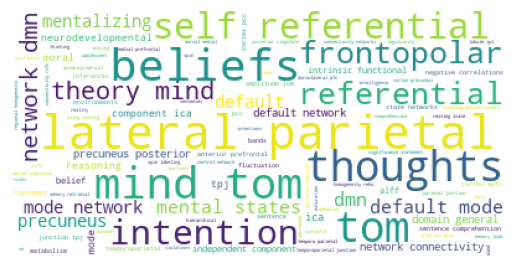

In [5]:
# and then do a similar decoding on the z_val vectors 
import matplotlib.pyplot as plt

from brainstat.context.meta_analysis import meta_analytic_decoder
from wordcloud import WordCloud

map = np.concatenate([z_val_left,z_val_right])
meta_analysis = meta_analytic_decoder("fsaverage5", map)
print(meta_analysis)

wc = WordCloud(background_color="white", random_state=0)
wc.generate_from_frequencies(frequencies=meta_analysis.to_dict()["Pearson's r"])
plt.imshow(wc)
plt.axis("off")
plt.show()